# Integrating Sentiment Analysis of Tweets for Stock Price Predictions


## Aims and ojectives

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

### Import stock data and the social media data

In [2]:
stock_df = pd.read_csv('stock.csv')
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [3]:
X_df = pd.read_csv('tweet.csv')
X_df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [4]:
# Check the number of rows and columns
X_df.shape

(80793, 4)

In [5]:
# Extracting unique values from the 'Stock Name' column in the DataFrame 
X_df['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [6]:
# Check the amount of time each unique value occured in the dataset, this reveals that Tesla stock data
# has the highest number of rows
X_df['Stock Name'].value_counts()

Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

In [7]:
df = X_df[X_df['Stock Name'] == 'AAPL']
df.head()

,Date,Tweet,Stock Name,Company Name
55958,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.
55959,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.
55960,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.
55961,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.
55962,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.


## Preprocessing the social media data

In [8]:
# Checking for the shape, the value type and if it contains a null value

print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 5056 entries, 55958 to 61013
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          5056 non-null   object
 1   Tweet         5056 non-null   object
 2   Stock Name    5056 non-null   object
 3   Company Name  5056 non-null   object
dtypes: object(4)
memory usage: 197.5+ KB
None
(5056, 4)


In [9]:
# Drop possible null value type and resetting the index
df = df.dropna().reset_index(drop=True)
df.shape

(5056, 4)

In [10]:
df.head(2)

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.
1,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.


### Creating three extra columns for assigning the sentiment score of each data point

In [11]:
df = df.assign(sentiment_score='', Negative='', Neutral='', Positive='')
df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,,,,
1,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,,,,
2,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,,,,
3,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,,,,
4,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,,,,


### Perform sentiment analysis on the social media data

In [12]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Al-
[nltk_data]     ameen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
final_df = df.copy()

In [15]:
%%time

sentiment_analyzer = SentimentIntensityAnalyzer()

# Loop through each row in the DataFrame
for idx, row in final_df.iterrows():
    try:
        # Extract the tweet text
        tweet_text = row['Tweet']
        
        # Analyze sentiment using VADER
        sentiment_scores = sentiment_analyzer.polarity_scores(tweet_text)
        
        # Update the DataFrame with sentiment scores
        final_df.at[idx, 'sentiment_score'] = sentiment_scores['compound']
        final_df.at[idx, 'Negative'] = sentiment_scores['neg']
        final_df.at[idx, 'Neutral'] = sentiment_scores['neu']
        final_df.at[idx, 'Positive'] = sentiment_scores['pos']
    
    except Exception as e:
        # Handle any exception that may occur
        print(f"Error processing tweet at index {idx}: {e}")
        break


CPU times: total: 2.44 s
Wall time: 2.42 s


In [16]:
final_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AAPL,Apple Inc.,0.25,0.158,0.684,0.158
1,2022-09-29 20:37:01+00:00,After trading for 9+ years \n\nThis is how to ...,AAPL,Apple Inc.,0.3612,0.0,0.915,0.085
2,2022-09-29 20:19:43+00:00,Not something you see very often. \n-2 ATR mo...,AAPL,Apple Inc.,0.0,0.0,1.0,0.0
3,2022-09-29 20:13:48+00:00,$AAPL was down almost 5% today. Rare to see it...,AAPL,Apple Inc.,-0.25,0.182,0.699,0.119
4,2022-09-29 19:50:00+00:00,$AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...,AAPL,Apple Inc.,-0.6523,0.143,0.857,0.0


In [17]:
final_df['Date'] = pd.to_datetime(final_df['Date']).dt.date
final_df = final_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [18]:
final_df['sentiment_score'] = pd.to_numeric(final_df['sentiment_score'], errors='raise').dropna()

In [19]:
tweet_df = pd.pivot_table(final_df, values='sentiment_score', index='Date', aggfunc='mean')

In [20]:
tweet_df.head()

,sentiment_score
Date,
2021-09-30,0.098900
2021-10-01,0.291891
2021-10-02,0.007525
2021-10-03,0.834400
2021-10-04,0.047410


In [21]:
tweet_df.shape

(365, 1)

## Preprocessing Apple stock data

In [22]:
stock_df = stock_df[stock_df['Stock Name'] == 'AAPL']
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [23]:
final_df = stock_df.join(tweet_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [24]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
1764,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,0.098900
1765,2021-10-01,141.899994,142.919998,139.110001,142.649994,141.620163,94639600,0.291891
1766,2021-10-04,141.759995,142.210007,138.270004,139.139999,138.135513,98322000,0.047410
1767,2021-10-05,139.490005,142.240005,139.360001,141.110001,140.091278,80861100,0.139060
1768,2021-10-06,139.470001,142.149994,138.369995,142.000000,140.974869,83221100,0.190330


### Plotting the closing value of Apple stock against the Date

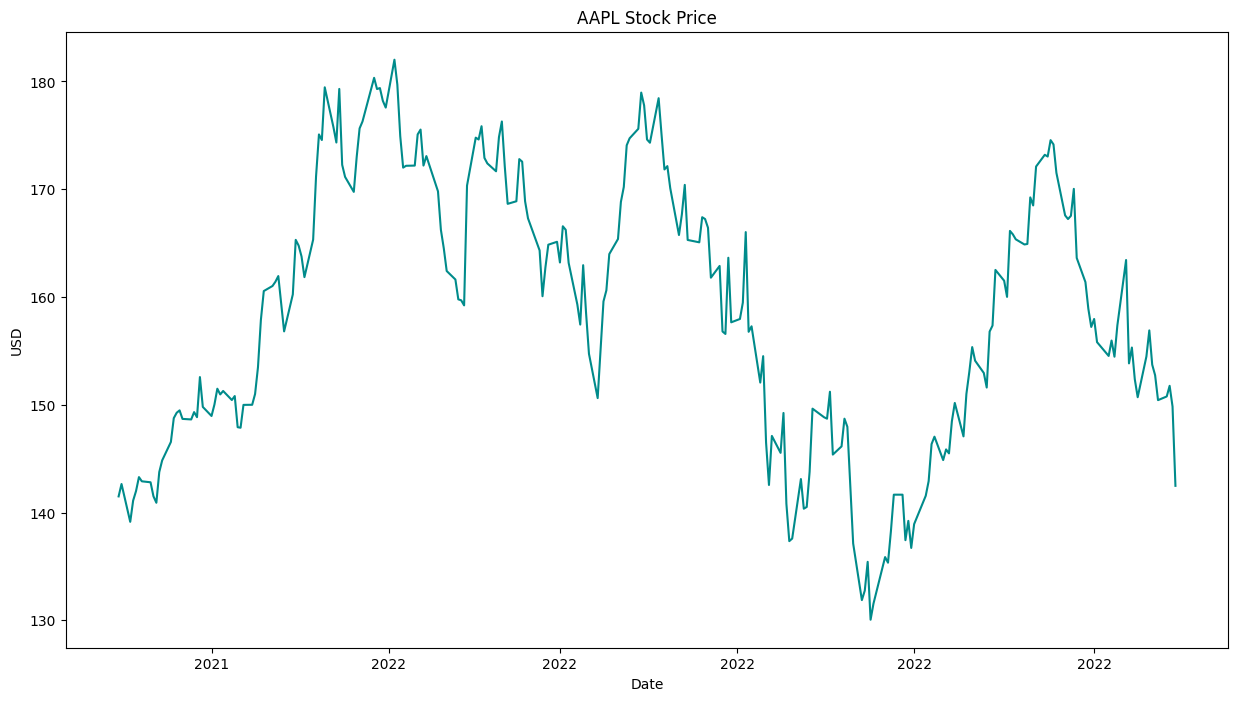

In [25]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title= "AAPL Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

### Adding technical indicators

In [26]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [27]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,149.820007,153.169998,149.720001,152.570007,151.468567,100077900,0.025634,149.544288,145.351999,-0.728923,3.815009,152.982017,137.721981,151.359926,5.021048
1,2021-10-29,147.220001,149.940002,146.410004,149.800003,148.718567,124953200,0.205803,149.621432,145.709499,-0.413809,3.882887,153.475272,137.943726,150.319977,5.002603
2,2021-11-01,148.990005,149.699997,147.800003,148.960007,147.884644,74588300,0.245867,149.547147,146.200500,-0.481039,3.620448,153.441395,138.959604,149.413330,4.996942
3,2021-11-02,148.660004,151.570007,148.649994,150.020004,148.936981,69122000,0.237369,149.737148,146.646000,-0.385045,3.507520,153.661040,139.630960,149.817780,5.004081
4,2021-11-03,150.389999,151.970001,149.820007,151.490005,150.396362,54511500,0.036300,150.144291,147.120500,-0.429116,3.487778,154.096056,140.144945,150.932597,5.013897


In [28]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

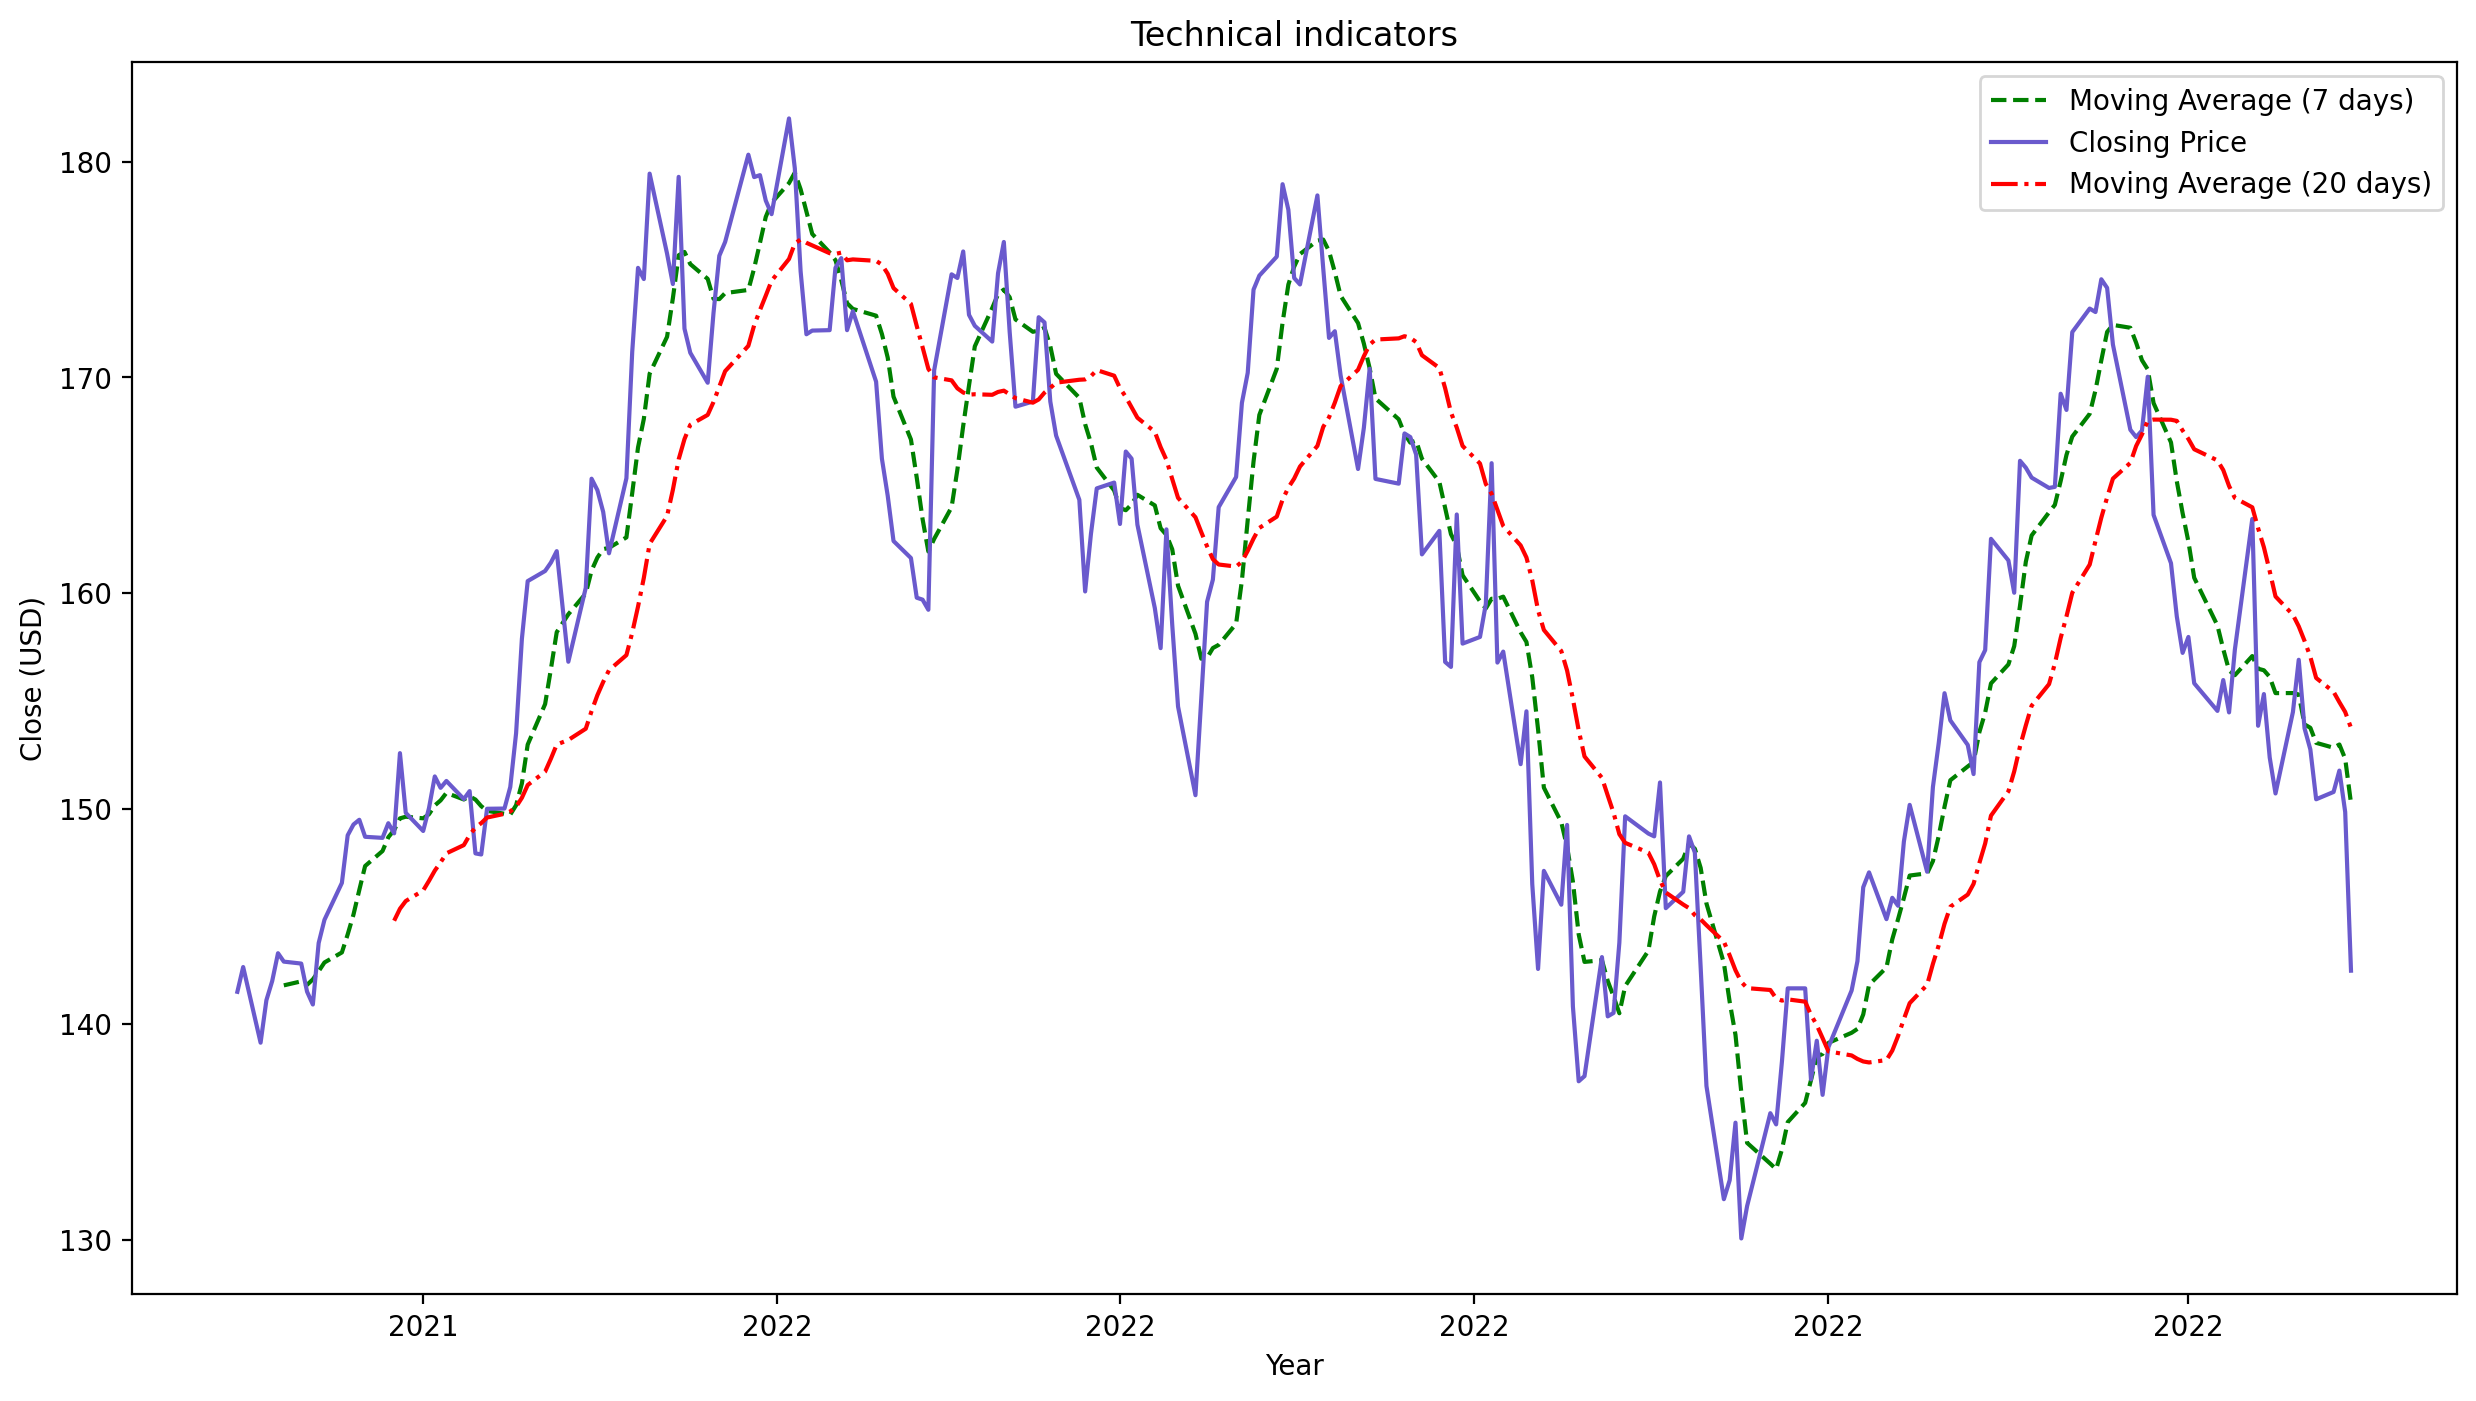

In [29]:
tech_ind(tech_df)

In [30]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [31]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [32]:
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2021-10-28,149.820007,153.169998,149.720001,152.570007,151.468567,100077900,0.025634,149.544288,145.351999,-0.728923,3.815009,152.982017,137.721981,151.359926,5.021048
2021-10-29,147.220001,149.940002,146.410004,149.800003,148.718567,124953200,0.205803,149.621432,145.709499,-0.413809,3.882887,153.475272,137.943726,150.319977,5.002603
2021-11-01,148.990005,149.699997,147.800003,148.960007,147.884644,74588300,0.245867,149.547147,146.200500,-0.481039,3.620448,153.441395,138.959604,149.413330,4.996942
2021-11-02,148.660004,151.570007,148.649994,150.020004,148.936981,69122000,0.237369,149.737148,146.646000,-0.385045,3.507520,153.661040,139.630960,149.817780,5.004081
2021-11-03,150.389999,151.970001,149.820007,151.490005,150.396362,54511500,0.036300,150.144291,147.120500,-0.429116,3.487778,154.096056,140.144945,150.932597,5.013897


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 2021-10-28 to 2022-09-29
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             232 non-null    float64
 1   High             232 non-null    float64
 2   Low              232 non-null    float64
 3   Close            232 non-null    float64
 4   Adj Close        232 non-null    float64
 5   Volume           232 non-null    int64  
 6   sentiment_score  232 non-null    float64
 7   MA7              232 non-null    float64
 8   MA20             232 non-null    float64
 9   MACD             232 non-null    float64
 10  20SD             232 non-null    float64
 11  upper_band       232 non-null    float64
 12  lower_band       232 non-null    float64
 13  EMA              232 non-null    float64
 14  logmomentum      232 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.0 KB


In [92]:
X=dataset.drop(['Close',], axis="columns")
y= dataset.Close

In [93]:
X.shape

(232, 14)

In [94]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [96]:
X_train.head()

,Open,High,Low,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2022-03-02,164.389999,167.360001,162.949997,165.809891,79724800,0.093460,163.837145,169.096001,2.375603,4.700620,178.497240,159.694761,165.613898,5.109334
2022-02-17,171.029999,171.910004,168.470001,168.119431,69589300,0.119550,171.448571,169.510000,-0.420115,5.763235,181.036469,157.983530,170.001165,5.123249
2022-03-09,161.479996,163.410004,159.410004,162.216141,91454900,0.190422,162.692856,166.169501,1.963879,4.873161,175.915822,156.423179,161.498574,5.087288
2021-12-01,167.479996,170.300003,164.529999,163.819244,152052500,-0.010063,161.641432,155.258002,-3.062051,5.829374,166.916749,143.599254,164.317134,5.098463
2022-02-02,174.750000,175.880005,173.330002,174.825333,84914300,0.251188,167.750000,169.298500,0.676428,5.964682,181.227863,157.369137,175.150093,5.163871


In [39]:
LR = linear_model.LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

In [40]:
LR.coef_

array([-3.46483601e-02,  1.27360979e-02,  4.71343857e-02,  8.52809609e-01,
        3.19471247e-09, -1.30870520e-03, -3.11389160e-03,  2.33929281e-02,
       -4.74433187e-03, -1.26025553e-02,  6.37477213e-03,  6.40947686e-02,
        1.26395014e+01])

In [41]:
predictions = LR.predict(X_test)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 0.1682639639658182
Mean Squared Error (MSE): 0.03767451484360682
Root Mean Squared Error (RMSE): 0.19409923967807505


In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
RG = RandomForestRegressor()
RG.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
Random_predictions = RG.predict(X_test)

In [46]:
mae = mean_absolute_error(y_test, Random_predictions)
mse = mean_squared_error(y_test, Random_predictions)
rmse = mean_squared_error(y_test, Random_predictions, squared=False)

print(f'RF Mean Absolute Error (MAE): {mae}')
print(f'RF Mean Squared Error (MSE): {mse}')
print(f'RF Root Mean Squared Error (RMSE): {rmse}')

RF Mean Absolute Error (MAE): 0.16866725285848125
RF Mean Squared Error (MSE): 0.05549309388648658
RF Root Mean Squared Error (RMSE): 0.2355697219221659


In [47]:
from sklearn.svm import SVR

In [48]:
SV = SVR()
SV.fit(X_train, y_train)

SVR()

In [49]:
SV_predictions = SV.predict(X_test)

In [50]:
mae = mean_absolute_error(y_test, SV_predictions)
mse = mean_squared_error(y_test, SV_predictions)
rmse = mean_squared_error(y_test, SV_predictions, squared=False)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}') 

Mean Absolute Error (MAE): 10.958164066276424
Mean Squared Error (MSE): 147.19552758624795
Root Mean Squared Error (RMSE): 12.13241639518888


In [51]:
comparison_df = pd.DataFrame({'Actual_CV': y_test, 'LR_Predicted_CV': predictions, 'RFR_Predicted_CV': Random_predictions, 'SVR_CV': SV_predictions})
comparison_df

,Actual_CV,LR_Predicted_CV,RFR_Predicted_CV,SVR_CV
2021-11-26,156.809998,156.659624,156.761400,160.484388
2022-06-06,146.139999,146.240288,146.337403,160.582409
2021-12-10,179.449997,179.204052,179.135903,159.697040
2022-08-26,163.619995,163.935595,163.903398,160.445589
2022-01-14,173.070007,172.966286,172.806499,160.416231
2021-12-02,163.759995,163.713856,163.641897,159.432351
2022-08-25,170.029999,170.313632,170.144000,160.851525
2021-12-31,177.570007,177.364110,178.426601,160.702729
2021-11-11,147.869995,147.594474,147.952102,160.915249
2022-03-14,150.619995,150.681336,150.807399,159.821003


In [75]:
X_test_date = X_test.reset_index()
X_test_date.rename(columns={'index': 'Date'}, inplace=True)
X_test_date

,Date,Open,High,Low,Adj Close,Volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-11-26,159.570007,160.449997,156.360001,155.905167,76959800,159.012859,153.181502,-2.557734,4.813162,162.807826,143.555177,158.422505,5.048637
1,2022-06-06,147.029999,148.570007,144.899994,145.695602,71598400,147.671430,145.548501,3.364032,4.772742,155.093985,136.003016,146.437253,4.977699
2,2021-12-10,175.210007,179.630005,174.690002,178.414505,115402700,170.169998,162.279001,-4.413952,8.210813,178.700627,145.857375,177.649553,5.184308
3,2022-08-26,170.570007,171.050003,163.559998,163.349014,78961000,168.807142,168.042500,-4.349131,4.159752,176.362005,159.722996,165.491754,5.091416
4,2022-01-14,171.339996,173.779999,171.089996,172.071350,80440800,173.175716,175.471500,-1.326522,3.516846,182.505192,168.437809,173.097233,5.147901
5,2021-12-02,158.740005,164.199997,157.800003,162.815063,136739200,162.032859,155.871501,-2.451656,6.053311,167.978122,143.764880,163.945708,5.092277
6,2022-08-25,168.779999,170.139999,168.350006,169.748413,51218200,170.368572,167.987000,-3.969585,4.228697,176.444395,159.529606,169.235271,5.130076
7,2021-12-31,178.089996,179.229996,177.259995,176.545395,64062300,178.098572,174.481500,-4.322316,4.890876,184.263252,164.699748,177.901493,5.173717
8,2021-11-11,148.960007,149.429993,147.679993,147.016754,41000000,150.110001,149.325501,-1.024480,1.767475,152.860452,145.790550,148.203086,4.989548
9,2022-03-14,151.449997,154.119995,150.100006,149.941650,108732100,158.104285,163.511001,2.576149,5.606782,174.724565,152.297437,152.521425,5.008099


In [80]:
linear_predictions_df = pd.DataFrame({'Date': X_test_date['Date'], 'Linear_Predictions': predictions})
random_predictions_df = pd.DataFrame({'Date': X_test_date['Date'], 'Random_Predictions': Random_predictions})
svm_predictions_df = pd.DataFrame({'Date': X_test_date['Date'], 'SVM_Predictions': SV_predictions})


# Merge the DataFrames on the 'Date' column
merged_df = pd.merge(X_test_date, linear_predictions_df, on='Date')
merged_df = pd.merge(merged_df, random_predictions_df, on='Date')
merged_df = pd.merge(merged_df, svm_predictions_df, on='Date')


merged_df.sort_values('Date', inplace=True)
merged_df.head(5)

,Date,Open,High,Low,Adj Close,Volume,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum,Linear_Predictions,Random_Predictions,SVM_Predictions,Close
8,2021-11-11,148.960007,149.429993,147.679993,147.016754,41000000,150.110001,149.325501,-1.024480,1.767475,152.860452,145.790550,148.203086,4.989548,147.594474,147.952102,160.915249,NaN
19,2021-11-16,149.940002,151.490005,149.339996,150.128677,59256200,149.718571,149.867502,-0.653196,1.236243,152.339988,147.395016,150.599374,5.010635,150.824142,150.895201,160.767174,NaN
0,2021-11-26,159.570007,160.449997,156.360001,155.905167,76959800,159.012859,153.181502,-2.557734,4.813162,162.807826,143.555177,158.422505,5.048637,156.659624,156.761400,160.484388,NaN
5,2021-12-02,158.740005,164.199997,157.800003,162.815063,136739200,162.032859,155.871501,-2.451656,6.053311,167.978122,143.764880,163.945708,5.092277,163.713856,163.641897,159.432351,NaN
2,2021-12-10,175.210007,179.630005,174.690002,178.414505,115402700,170.169998,162.279001,-4.413952,8.210813,178.700627,145.857375,177.649553,5.184308,179.204052,179.135903,159.697040,NaN


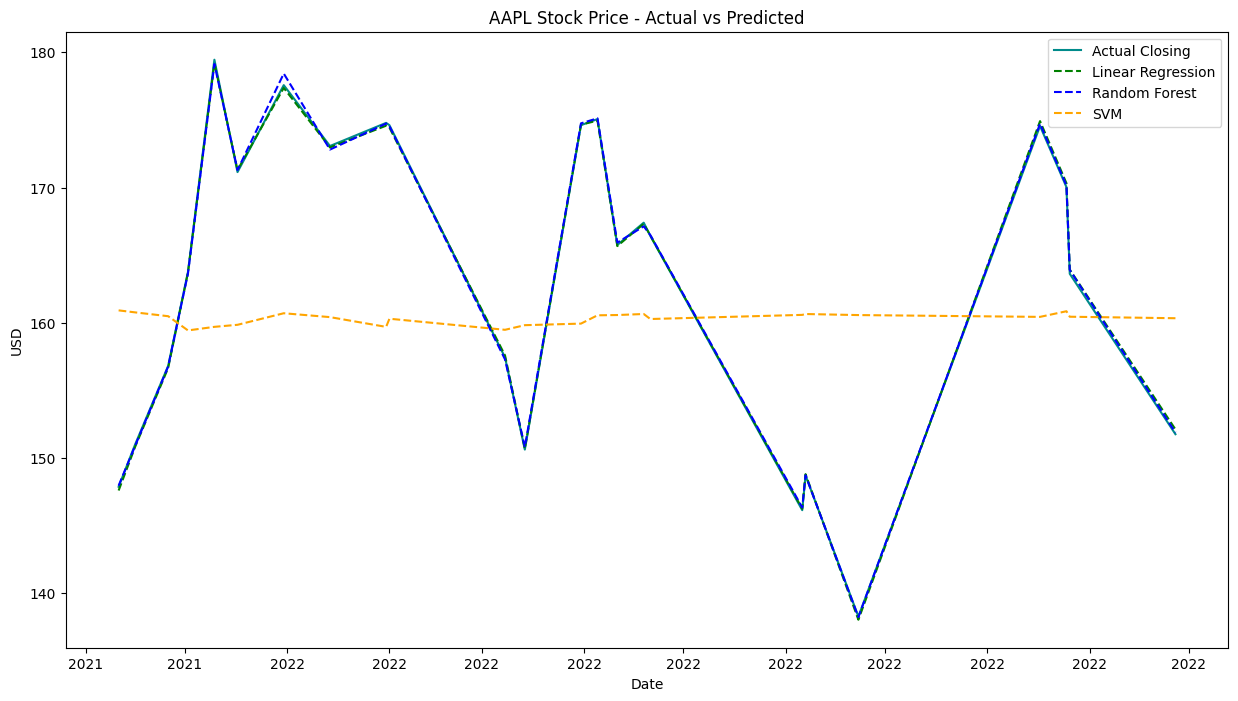

In [82]:
fig, ax = plt.subplots(figsize=(15, 8))


ax.plot(merged_df['Date'], y_test, label='Actual Closing', color='#008B8B')
ax.plot(merged_df['Date'], merged_df['Linear_Predictions'], label='Linear Regression', color='green', linestyle='--')
ax.plot(merged_df['Date'], merged_df['Random_Predictions'], label='Random Forest', color='blue', linestyle='--')
ax.plot(merged_df['Date'], merged_df['SVM_Predictions'], label='SVM', color='orange', linestyle='--')

ax.set(xlabel="Date", ylabel="USD", title="AAPL Stock Price - Actual vs Predicted")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.legend()

plt.show()

In [90]:
data = {
    'Model': ['Logistic Regression', 'Random Forest Regression', 'Support Vector Machine'],
    'Mean Absolute Error (MAE)': [0.1682639639658182, 0.16866725285848125, 10.958164066276424],
    'Mean Squared Error (MSE)': [0.03767451484360682, 0.05549309388648658, 147.19552758624795],
    'Root Mean Squared Error (RMSE)': [0.19409923967807505, 0.2355697219221659, 12.13241639518888]
}

In [91]:
evaluation_df = pd.DataFrame(data)
evaluation_df

,Model,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE)
0,Logistic Regression,0.168264,0.037675,0.194099
1,Random Forest Regression,0.168667,0.055493,0.235570
2,Support Vector Machine,10.958164,147.195528,12.132416
